No handles with labels found to put in legend.


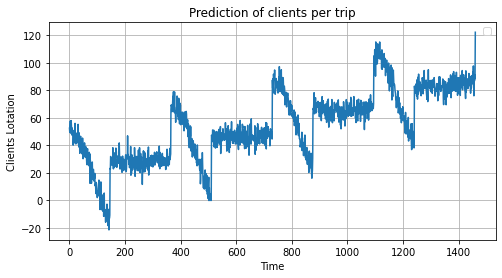

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None , label = None):
    plt.title("Prediction of clients per trip")
    plt.plot(time[start:end], series[start:end], format, label =label);
    plt.xlabel("Time")
    plt.ylabel("Clients Lotation")
    plt.grid(True)
    plt.legend();

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(8, 4))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

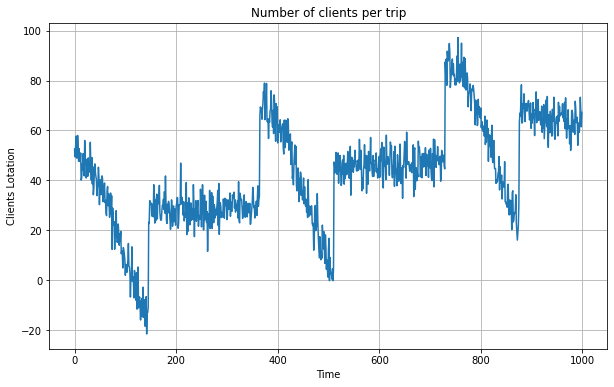

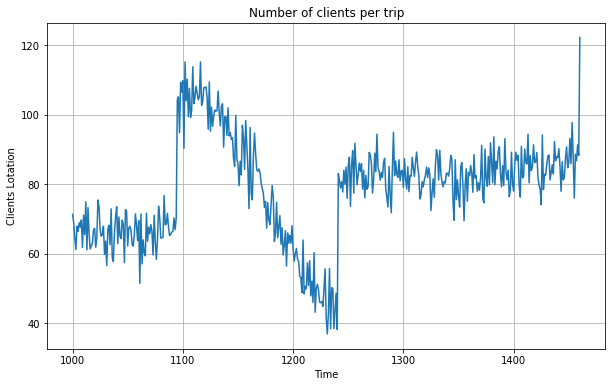

In [13]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plt.title("Training Data")
plot_series(time_train, x_train)
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Validation Data")
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [14]:
naive_forecast = series[split_time - 1:-1]

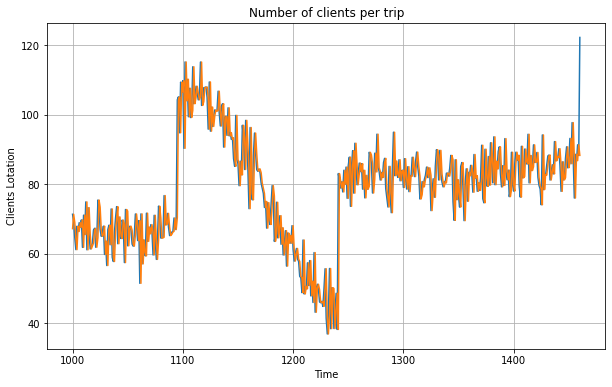

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

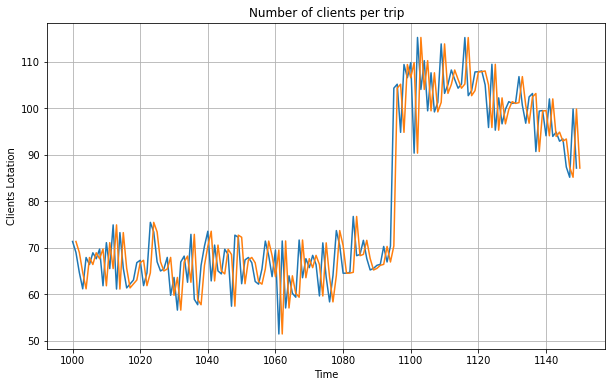

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [17]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.9379086


That's our baseline, now let's try a moving average:

In [18]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

461 461


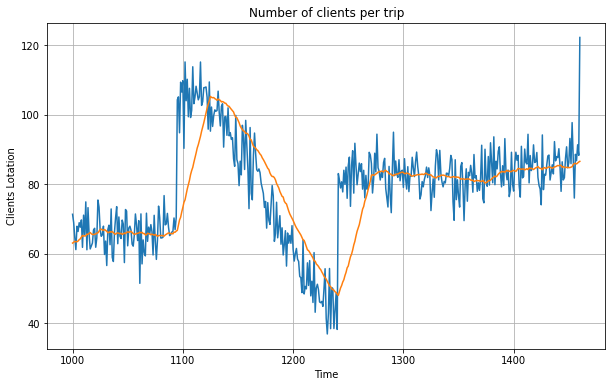

In [19]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
print(len(moving_avg),len(x_valid))
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [20]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

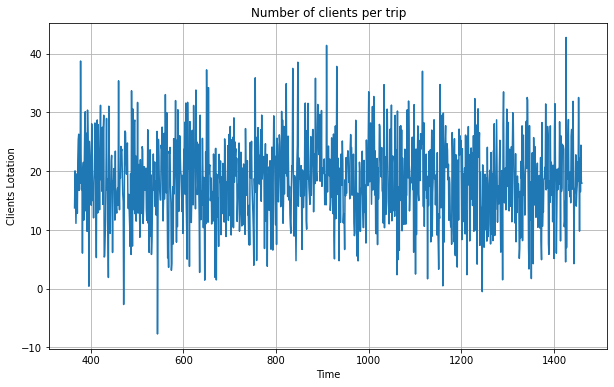

In [21]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

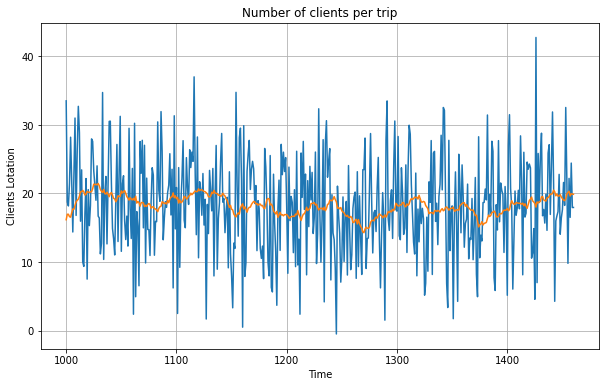

In [22]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

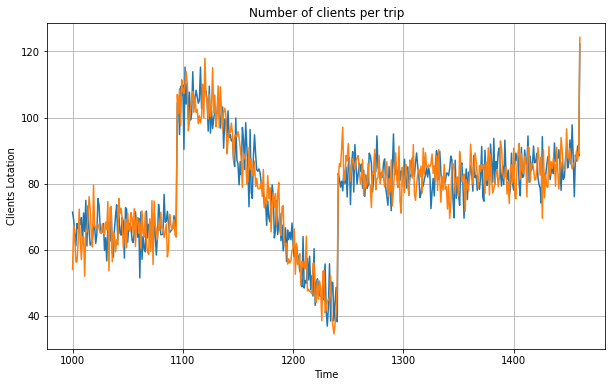

In [23]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [24]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764587
5.9032416


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

In [31]:
plt.vlines?

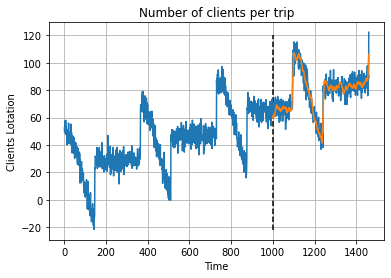

In [39]:
plot_series(time,series)
plot_series(time_valid,diff_moving_avg_plus_smooth_past)
plt.vlines(time_valid[0],-22,120,linestyles='dashed');

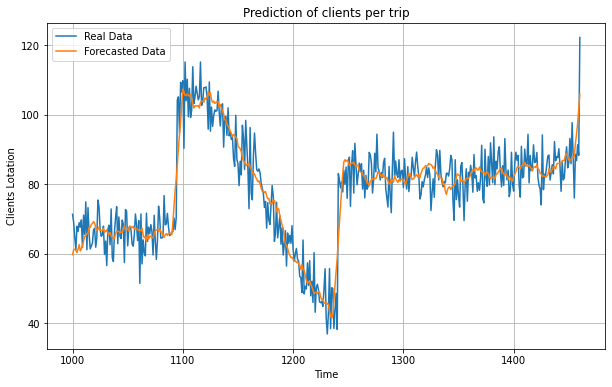

In [43]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,label='Real Data')
plot_series(time_valid, diff_moving_avg_plus_smooth_past,label='Forecasted Data')
plt.show()

In [26]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.885323
4.587621
